### Information Retrieval   |    Assignment 1-B

In [8]:
import pandas as pd
import numpy as np
import sys
import os
import random as rnd
import time
from collections import defaultdict
from functools import reduce
import math

In [2]:
# Open file    
fileHandler = open ('YandexRelPredChallenge.txt', "r")
# Get list of all lines in file
listOfLines = fileHandler.readlines()
# Close file 
fileHandler.close()
#Empty frame to fill in
index=[x for x in range(0,100000)]
df = pd.DataFrame(index=index, columns=['SessionID', 'TimePassed',
                 'TypeOfAction', 'QueryID','RegionID', 'ListOfURLs', 'URLID'])
df.name='data'

# Iterate over the lines and fill in the dataframe
for ind, line in zip(index, listOfLines):
#     print('index')
    line = line.strip().split()
    if line[2]=='Q':

        df.loc[ind] = pd.Series({'SessionID':line[0], 'TimePassed':line[1], 'TypeOfAction':line[2],
                                     'QueryID':line[3],'RegionID':line[4], 'ListOfURLs':line[5:], 'URLID':np.nan})
    else:
        df.loc[ind] = pd.Series({'SessionID':line[0], 'TimePassed':line[1], 'TypeOfAction':line[2],
                                     'QueryID':np.nan,'RegionID':np.nan, 'ListOfURLs':np.nan, 'URLID':line[3:]})

In [3]:
# Getting the types right. 
df.SessionID = df.SessionID.astype(int)
df.TimePassed = df.TimePassed.astype(int)
df.TypeOfAction = df.TypeOfAction.astype(str)
df.RegionID = df.RegionID.astype(float)
df.TimePassed = df.TimePassed.astype(float)
def parse_ulrid(x):
    if type(x)==list:
        return x[0]
    else:
        return x
df.URLID = df.URLID.apply(parse_ulrid)
df.URLID = df.URLID.astype(float)

### Step 1:

Create new relevance:

So lets say that our experimental system is what Yandex return as a list now. Production or the system that is going to 'suck' (sort of a dumb system that we are going to compare against) will be constructed as shuffling each ranking for a query. 

Now, other approach, probably the better one: take the initial order as the 'benchmark' create only list of 0,1 (relevnace scores) for each system.
    - rember that we are interested only in three [3] first results.

In [ ]:
# Create new relevance scores 
relevances = [0,1]
doc_length = 3 

relevance_pairs=["".join(seq) for seq in itertools.product("01", repeat=6)]
relevance_pairs = [(p[:3],p[3:])for p in relevance_pairs]

### Step 2: Calculate ERR

In [ ]:
def ERR(l):
    theta = [ (2**i - 1)/(2) for i in [0,1]]
    err=0
    
    for rank in range(len(l)):
        prod = 1
        for idx in range(rank):
            prod*=(1-theta[int(l[idx])])
        prod*=(1/(rank+1))*theta[int(l[rank])]
        err+=prod
    return err


see the formuala for ERR at: http://olivier.chapelle.cc/pub/err.pdf

Get the deltas

In [40]:
binned = { x/100:[]for x in range(10,100,5) }#all below 0.05 is discarded The numbers are the upperbound
for tup in relevance_pairs:
    d_err = ERR(tup[0]) - ERR(tup[1])
    if d_err<0.05:
        continue #discard this entry
    
    d_err =int(5 * round((d_err*100)/5))/100
    binned[d_err].append(tup)

### Step 3

In [ ]:
def create_possible_permutations(tup):
    ids=['a','b','c','d','e','f']
    pair1 = ['a','b','c']
    rel1  = tup[0]
    rel2  = tup[1]
    possible_pairs = []
    
    possible_ids = []
    for idx in range(3):
        possible_ids.append([ids[idx+3]])
        for _id,r1 in enumerate(rel1):
                if r1==rel2[idx]:
                    possible_ids[idx].append(ids[_id])
                    
    for l0 in possible_ids[0]:
        for l1 in possible_ids[1]:
            for l2 in possible_ids[2]:
                if l0 is not l1 is not l2 is not l0:
                    possible_pairs.append([l0,l1,l2])
    pairs = []
    for p in possible_pairs:
        pairs.append((pair1,p))
    return pairs
         

In [ ]:
def team_draft(tup,start=0,):
    l = []
    tup = (list(tup[0]),list(tup[1]))
    for idx in range(6):
        start+=1
        if len(tup[start%2])==0:continue
        elem = tup[start%2].pop(0)
        tup = (list(filter(lambda a: a != elem, tup[0])), list(filter(lambda a: a != elem, tup[1])))
        l.append((elem,start%2))
    return l

def probabelistic_interleaving(tup):
    l = []
    tup = (list(tup[0]),list(tup[1]))

    for x in range(6):
        active=[]
        if(len(tup[0]))>0:active+=[0]
        if(len(tup[1]))>0:active+=[1]    
        if not active:break
        cur = np.random.choice(active)#get the currently selected model
        
        unnormalized_probs=[]
        for idx in range(len(tup[cur])):
            unnormalized_probs.append(1/((idx+1)**3))#tau is 3 from the paper
        unnormalized_probs = [x/sum(unnormalized_probs) for x in unnormalized_probs]
        elem = np.random.choice(tup[cur],p=unnormalized_probs)
        tup = (list(filter(lambda a: a != elem, tup[0])), list(filter(lambda a: a != elem, tup[1])))
        l.append((elem,cur))
    return l

In [ ]:
l = create_possible_permutations(['111','111'])
print(probabelistic_interleaving(l[10]))
print(team_draft(l[10]))

print(l[10])

### Step 4.1: Estimating the params of click models: Random Click Model

In [179]:
# Get all the doc ids
data = df.drop(columns=['id_rel_e', 'id_rel_p', 'rel_e', 'rel_p', 'id_e',
       'id_p', 'err_e', 'err_p'])
data.QueryID = data.QueryID.astype(float)
list_doc_ids_raw = data.ListOfURLs[df.ListOfURLs.isnull()!=True].values
res = list()
for i in list_doc_ids_raw:
    res += i
all_doc_ids = res.copy()
# Get all the clicks
list_clicks_ids = data.URLID[df.URLID.isnull()!=True].values

# rho = probability of a doc to be clicked.
rho = len(list_clicks_id)/len(all_doc_ids)
print(rho)

0.13445559411047547


### Step 4.2: Estimating the params of click models: Posistion-based Model

Prepare the data for training
    - assumption: we assume that all the queries have at least 3 docs shown.
    
    TODO: check if true

In [ ]:
data = df.copy()
data.QueryID = data.QueryID.astype(float)

In [6]:
# Create the tables with all the params
n_docs = 3
unique_queries = data.QueryID[data.QueryID.isnull()!=True].astype(int).unique()
n_queries = len(unique_queries) 

In [28]:
start = time.time()

# Create query_doc empty pairs
query_doc_pairs = defaultdict()
for i in unique_queries:
    query_doc_pairs[i]=[]
    
# This code will give an error at the very last session ! -> move last session to the different bit.
sessions = data.SessionID.unique()[:-1]
for session in sessions:
    data_session = data[data.SessionID==session]
    click_ids =  data_session.URLID[data_session.URLID.isnull()!=True].values
    query_ids = data_session.QueryID[data_session.QueryID.isnull()!=True].values
    for query_id in query_ids:
        first_3_docs = data_session.ListOfURLs[data.QueryID==query_id].iloc[0]
        first_3_docs = np.array(list(map(int,first_3_docs))[:3])
        # take index in the current data_session
        query_id_ind = data_session.QueryID[data_session.QueryID==query_id].index[0]
        flag = not math.isnan(data.URLID.iloc[query_id_ind+1])
        # if the next entry is click
        if flag:
            click_log = np.array([0,0,0])
            query_id_ind+=1
            while flag==1:
                click_urlid = data.URLID.iloc[query_id_ind]
                # if click_urlid in first_3_docs then click is 1 on that position.
                doc_u_id = np.where(first_3_docs==click_urlid)
                click_log[doc_u_id]=1
                # increase the count
                query_id_ind +=1
                flag = not math.isnan(data.URLID.iloc[query_id_ind])
            # do updates
        else:
            click_log = np.array([0,0,0])
            # do updates
            
        # Save query_id-click_log (=session-doc) pair for each query_id
        query_doc_pairs[query_id].append(click_log)
    
end = time.time()
print(f'suka bleyat, but still kinda quick tho : seconds spent {end - start}, mins spent {(end - start)/60}')

suka bleyat, but still kinda quick tho : seconds spent 89.54805207252502, mins spent 1.4924675345420837


In [10]:
query_doc_pairs_old = query_doc_pairs.copy()
# query_doc_pairs_old

Perform EM steps (update assignments ; update params):
    
    1) initialize alpha and gamma at random 
    2) For each time step:
        - Expecation: do not really have to do this step [?], what we want to see at the end: P(C|u) 
            - calculate P(C|u) for each u (u is from 1 to 3 = positions in the shown list)
            - " P(C|u) = P(A_uq|E,u)P(E|u) "
                
        - Maximization: update alpha and gamma params
        


### Alphas 

In [11]:
alphas = np.random.rand(n_docs*n_queries).reshape((n_docs,n_queries))

assert unique_queries.shape[0] == alphas.shape[1], 'Error, bleayt'

# for comparison :
alphas_old = alphas.copy()

In [12]:
start = time.time()

# Do the updates for alphas:

def train_alphas(alphas, gammas, query_doc_pairs, n_docs):
    # refer to alphas array with query_num as that it is how the are strored there:
    for query_num, query_id in enumerate(query_doc_pairs):
        for doc_u in range(n_docs):
            factor_1 = 1/len(query_doc_pairs[query_id])
            summ =  0
            for sessions_docs in query_doc_pairs[query_id]:
                click = sessions_docs[doc_u]
                summ += click + (1-click)*( (1-gammas[doc_u])*alphas[doc_u][query_num] ) / \
                                            (1-gammas[doc_u]*alphas[doc_u][query_num])
            alphas[doc_u][query_num] = factor_1*summ
    return alphas

alphas = train_alphas(alphas, gammas, query_doc_pairs, n_docs)

end = time.time()
print(f'seconds spent {end - start}, mins spent {(end - start)/60}')

seconds spent 1.0285494327545166, mins spent 0.01714249054590861


In [17]:
# Is that true that we ve changed every alpha ?
print('Is that true that we ve changed every alpha ? ->', not (alphas_old == alphas).any())
assert alphas_old.shape == alphas.shape, 'new shapes are fucked up'


Is that true that we ve changed every alpha ? -> True


### Gammas

We normalize by all the sessions.

In [18]:
gammas = np.random.rand(n_docs)

all_sess = [ query_doc_pairs[idd] for idd in query_doc_pairs]
all_sess = reduce(lambda x,y: x+y, all_sess)

# for comparison :
gammas_old = gammas.copy()

In [20]:
start = time.time()

# Do the updates for gammas:

def train_gammas(alphas, gammas, query_doc_pairs, n_docs):
    for doc_u in range(n_docs):
        # refer to alphas array with query_num as that it is how the are strored there:
        summ =  0
        for query_num, query_id in enumerate(query_doc_pairs):
            factor_1 = 1 / len(all_sess)
            for sessions_docs in query_doc_pairs[query_id]:
                click = sessions_docs[doc_u]
                summ += click + (1-click)*( (1-alphas[doc_u][query_num])*gammas[doc_u] ) / \
                                            (1-gammas[doc_u]*alphas[doc_u][query_num])        
        gammas[doc_u] = factor_1 * summ
    
    return gammas

gammas = train_gammas(alphas, gammas, query_doc_pairs, n_docs)

end = time.time()
print(f'seconds spent {end - start}, mins spent {(end - start)/60}')

seconds spent 1.023488998413086, mins spent 0.017058149973551432


In [25]:
# Test to see if we have all queries filled in
def check_sanity(l):
    if l==[]:
        return False
    else:
        return True
test = pd.Series(query_doc_pairs)
test_res = test.apply(check_sanity)
print('should be all true, coz otherwise we have queries with no sessions', np.unique(np.array(test_res)))

assert gammas_old.shape == gammas.shape, 'shapes are fucked'

should be all true, coz otherwise we have queries with no sessions [ True]


#### Training multiple times

In [47]:
gammas = np.random.rand(n_docs)
alphas = np.random.rand(n_docs*n_queries).reshape((n_docs,n_queries))

#  Training till convergence: 
n_epochs = 100
diff_alphas = [1]
diff_gammas = [1]

for i in range(n_epochs):
    gammas = train_gammas(alphas, gammas, query_doc_pairs, n_docs)
    alphas = train_alphas(alphas, gammas, query_doc_pairs, n_docs)
    
    #For plotting: checking convergence
    diff_alphas.append( diff_alphas[-1] - sum(sum(alphas)) )
    diff_gammas.append( diff_gammas[-1] - sum(gammas) )
    
    

/home/marr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


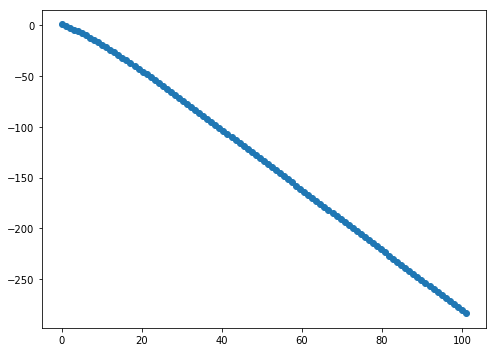

In [48]:
import matplotlib.pyplot as plt

x = np.linspace(0, n_epochs+1, n_epochs+1)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x,diff_gammas,marker='x')
fig.tight_layout()

In [56]:
diff_alphas = list(map(sum,diff_alphas[1:]))

In [59]:
gammas

array([1.        , 0.9999976 , 0.99994865])